## Summary of Notebook

This notebook contains the implementation of the EfficientNetB0 model with frozen architecture. It provides the results obtained from this model and its performance across the training, validation, and testing phases.

## Set Up
Here, we will begin by downloading the necessary dataset for flowers102, followed by the creation of dataloaders and the implementation of train and test functions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from scipy.io import loadmat
import pandas as pd
from torch.utils.data import Dataset
import json

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
train_dataset = torchvision.datasets.Flowers102("./data/train", split="train", download=True, transform=data_transforms["train"])
val_dataset = torchvision.datasets.Flowers102("./data/val", split="val", download=True, transform=data_transforms["val"])
test_dataset = torchvision.datasets.Flowers102("./data/test", split="test", download=True, transform=data_transforms["test"])

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
dataloaders = {}
dataloaders["train"] = train_dataloader
dataloaders["val"] = val_dataloader
dataloaders["test"] = test_dataloader

In [6]:
dataset_sizes = {}
dataset_sizes["train"] = len(train_dataloader.dataset)
dataset_sizes["val"] = len(val_dataloader.dataset)
dataset_sizes["test"] = len(test_dataloader.dataset)

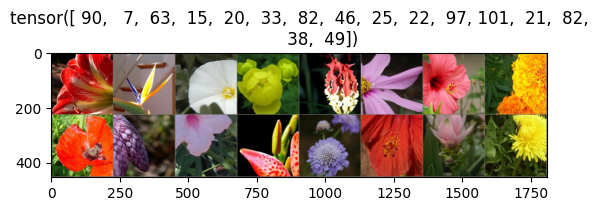

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)



In [8]:
def test_model(model, criterion):
    model.to("cpu")  # Ensure the model is on CPU
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloaders["test"]:
            # Ensure inputs and labels remain on CPU
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # Compute average loss and accuracy
    total_loss = running_loss / dataset_sizes["test"]
    total_acc = running_corrects.double() / dataset_sizes["test"]
    
    return total_loss, total_acc


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_accuracies = []
    val_accuracies = []

    # Ensure model is on the correct device (CPU in this case)
    device = torch.device("cpu")
    model = model.to(device)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # Save initial model state
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    # Ensure inputs and labels are on the correct device (CPU)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Step the learning rate scheduler only during training
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Store accuracy for each epoch
                if phase == 'train':
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_accuracies, val_accuracies


In [10]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_conv = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Modify Last Layer and Freeze the Other Layers

In this section, we will train the EfficientB0 model on the flowers102 dataset. Our only modification will be adjusting the last layer to have 102 neurons. The remaining architecture of EfficientB0 will remain unchanged, with all other layers frozen.

In [11]:
num_ftrs = model_conv.classifier[1].in_features

for param in model_conv.parameters():
    param.requires_grad = False

# change the loss layer with 102 output neurons
model_conv.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, 102),
        )


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [12]:
model_conv, train_accuracies_conv, val_accuracies_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.2990 Acc: 0.1275
val Loss: 3.4225 Acc: 0.5627

Epoch 1/24
----------
train Loss: 3.1525 Acc: 0.5333
val Loss: 2.4198 Acc: 0.7284

Epoch 2/24
----------
train Loss: 2.3722 Acc: 0.6951
val Loss: 1.8290 Acc: 0.7951

Epoch 3/24
----------
train Loss: 1.8714 Acc: 0.7725
val Loss: 1.4890 Acc: 0.8216

Epoch 4/24
----------
train Loss: 1.5489 Acc: 0.8088
val Loss: 1.2560 Acc: 0.8353

Epoch 5/24
----------
train Loss: 1.3042 Acc: 0.8245
val Loss: 1.0622 Acc: 0.8529

Epoch 6/24
----------
train Loss: 1.1267 Acc: 0.8520
val Loss: 0.9793 Acc: 0.8578

Epoch 7/24
----------
train Loss: 1.0192 Acc: 0.8824
val Loss: 0.9696 Acc: 0.8539

Epoch 8/24
----------
train Loss: 1.0365 Acc: 0.8706
val Loss: 0.9497 Acc: 0.8559

Epoch 9/24
----------
train Loss: 1.0562 Acc: 0.8686
val Loss: 0.9606 Acc: 0.8569

Epoch 10/24
----------
train Loss: 1.0162 Acc: 0.8657
val Loss: 0.9429 Acc: 0.8588

Epoch 11/24
----------
train Loss: 1.0012 Acc: 0.8804
val Loss: 0.9322 Acc: 0.8627

Ep

C:\Users\Arnav\AppData\Local\Temp\ipykernel_113736\3105844241.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


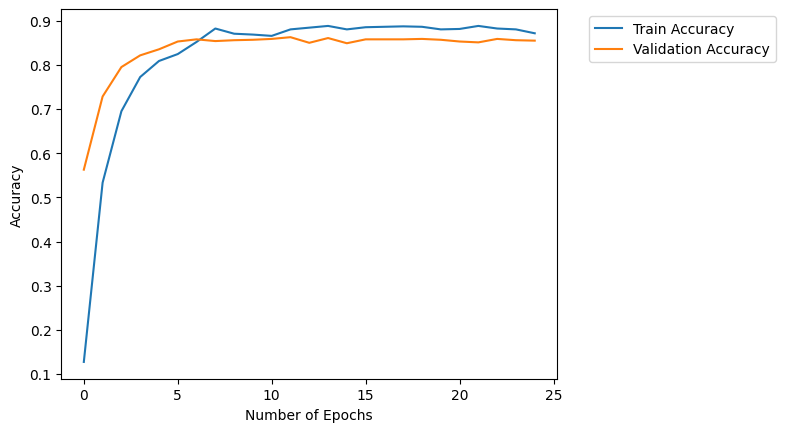

In [13]:
plt.plot(range(25), train_accuracies_conv, label="Train Accuracy")
plt.plot(range(25), val_accuracies_conv, label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # Ensure inputs and labels remain on CPU
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]} vs true: {labels[j]}')
                imshow(inputs.data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)


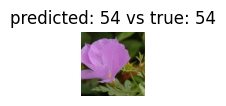

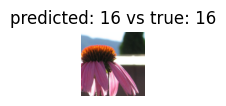

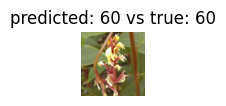

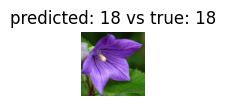

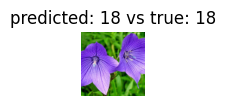

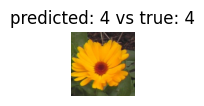

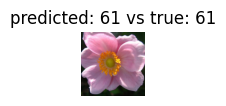

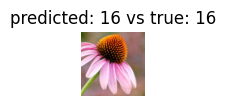

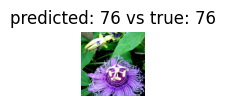

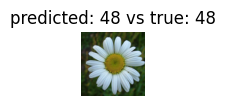

In [15]:
visualize_model(model_conv, num_images=10)

In [16]:
criterion = nn.CrossEntropyLoss()
loss_conv, accuracy_conv = test_model(model_conv, criterion)

In [17]:
print(f"{ 'Test Loss (Freeze)'.ljust(30) } : {loss_conv:.4f}")
print(f"{ 'Test Accuracy (Freeze)'.ljust(30) } : {accuracy_conv:.4f}")

Test Loss (Freeze)             : 1.0189
Test Accuracy (Freeze)         : 0.8385
